In [60]:
using LinearAlgebra
using Plots
using DelimitedFiles
using LightGraphs
using StatsBase
using Distributions

In [62]:
# create the network that we need.
G = Graph(98)
node_labels=["public Space"]

1-element Array{String,1}:
 "public Space"

In [63]:
# 1 public space connecting all the places.
# 2-31 restaurant 2-7 cluster 8-31 restaurant
# 32-79 retail 32-39 cluster 40-79 store
# 80-92 cinema 80 cluster 81-92 cinema
# 93 gym 94-97 gym

In [64]:
# add cluter to 1
for i in 2:7
    add_edge!(G, 1, i)
end
for i in 32:39
    add_edge!(G,1,i)
end

add_edge!(G,1,80)
add_edge!(G,1,93)
add_edge!(G,1,98)

true

In [65]:
# add shop to cluster
for i in 1:6
    for j in 1:4
        add_edge!(G, i+1, 4*i-4+j+7)
    end
end
for i in 1:8
    for j in 1:5
        add_edge!(G, i+31, 5*i-5+j+39)
    end
end

for i in 1:1
    for j in 1:12
        add_edge!(G, i+79, 12*i-12+j+80)
    end
end

for i in 1:1
    for j in 1:4
        add_edge!(G, i+92, 4*i-4+j+93)
    end
end


In [66]:
for i in 2:7
     push!(node_labels,"restaurant cluster")
end

for i in 8:31
    push!(node_labels, "restaurant $(i-7)")
end

for i in 32:39
    push!(node_labels, "retail store cluster")
end

for i in 40:79
    push!(node_labels, "retail store $(i-39)")
end

push!(node_labels, "cinema cluster")
for i in 81:92
    push!(node_labels, "cinema room $(i-80)")
end

push!(node_labels, "gym cluster")

for i in 94:97
    push!(node_labels, "gym room $(i-93)")
end

push!(node_labels, "Home")

98-element Array{String,1}:
 "public Space"
 "restaurant cluster"
 "restaurant cluster"
 "restaurant cluster"
 "restaurant cluster"
 "restaurant cluster"
 "restaurant cluster"
 "restaurant 1"
 "restaurant 2"
 "restaurant 3"
 "restaurant 4"
 "restaurant 5"
 "restaurant 6"
 ⋮
 "cinema room 7"
 "cinema room 8"
 "cinema room 9"
 "cinema room 10"
 "cinema room 11"
 "cinema room 12"
 "gym cluster"
 "gym room 1"
 "gym room 2"
 "gym room 3"
 "gym room 4"
 "Home"

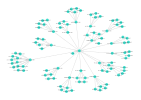

In [67]:
gplot(G, nodelabel=node_labels, NODELABELSIZE=1)

In [68]:
mutable struct Person
    isInfected
    isEmployee
    hadMeal
    exposed
    isBackHome
    isWatchingMovie
    schedule
    intervention
end

In [69]:
#= 
9000 people in the mall every day.
1000 exployee
test for 30 days
Employee will work from 10-12, 1-5, 6-9
    -other hours will choose to eat at restaurant
Customer will choose to go to a random note in the network to spend an hour
    -Exception for when at movie theater
    -Exception for restaurant will not be picked right after each other
=#

In [70]:
# Need to prevent two restaurant right next to each other-fixed
function generateScheduleCustomer(person)
    person.schedule=[]
    for i in 10:21
        if(!person.isBackHome)
            if(!person.isEmployee)
                if(person.isWatchingMovie)
                    push!(person.schedule,person.schedule[length(person.schedule)])
                    person.isWatchingMovie=false
                    continue
                end
                if(i>17 && !person.hadMeal)
                    push!(person.schedule, rand(40:79))
                    person.hadMeal=true
                end
                place=rand(1:98)
                if (person.hadMeal)
                        place=rand(1:98)
                        while(place >= 8 && place <= 31)
                            place=rand(1:98)
                        end
                end
                if(place >= 8 && place <= 31)
                        person.hadMeal=true
                end
                if(place >= 81 && place <= 92)
                    person.isWatchingMovie=true
                end
                push!(person.schedule,place)
            end
        end
    end
end

generateScheduleCustomer (generic function with 1 method)

In [71]:
function generateScheduleEmployee(person)
    workposition=rand(1:97)
    workhour=0
    person.schedule=[]
    for i in 10:21
        if workhour == 7
            push!(person.schedule, 98)
        else
            freetime=rand(1:10)
            if freetime==10
                push!(person.schedule, rand(8:31))
                person.hadMeal=true
            else
                push!(person.schedule, workposition)
                workhour+=1
            end
        end
    end
end

generateScheduleEmployee (generic function with 1 method)

In [72]:
function generateEmployeeAndCustomer(e,c)
    res=[]
    for i in 1:e
        isInfected = rand(1:10000)<6
        expose = isInfected ? 3 : 1
        employee=Person(isInfected,true,false,expose,false,false,[],[])
        push!(res,employee)
    end
    for i in 1:c
        isInfected = rand(1:10000)<6
        expose = isInfected ? 3 : 1
        customer=Person(isInfected,false,false,expose,false,false,[],[])
        push!(res,customer)
    end
    return res
end

generateEmployeeAndCustomer (generic function with 1 method)

In [73]:
function generateSchedule(people, startpoint, endpoint)
    isEmployee=people[startpoint].isEmployee
    for i in startpoint:endpoint
        if isEmployee
            generateScheduleEmployee(people[i])
        else
            generateScheduleCustomer(people[i])
        end
    end
end

generateSchedule (generic function with 1 method)

In [74]:
function location!(places,people, iteration)
    i = 1
    for p in places
        places[i]=[]
        i+=1
    end
    i=1
    for p in people
        push!(places[p.schedule[iteration]], i)
        i+=1
    end
end

location! (generic function with 1 method)

In [75]:
function hasCovid(people, place)
    sum=0
    for p in place
        if people[p].isInfected==true && people[p].exposed>2
            sum+=1
        end
    end
    return sum
end

hasCovid (generic function with 1 method)

In [76]:
emplyeeNum=1000
customerNum=4000
people=generateEmployeeAndCustomer(emplyeeNum,customerNum)
generateSchedule(people,1,1000)
generateSchedule(people,1001,5000)
length(filter((x)->x.isInfected, people))
places=[]
for i in 1:98
    push!(places, [])
end

In [77]:
totalInfection = []
totalPeople = 1000
daily=[]
for x in 1:30
    d = 0
    for i in 1:12
        location!(places,people,i)
        for place in places
            infect = hasCovid(people, place)
        
            rate = 1*1.25*infect/100
            for p in place
                people[p].isInfected = people[p].isInfected || rand(Float64)<rate
            end
        end
    end
    for i in 1:1000
        if people[i].isInfected
            people[i].exposed +=1
        end
    end
    totalPeople+=4000
    for i in 1001:5000
        if people[i].isInfected
            d+=1
        end
        isInfected = rand(1:10000)<6
        expose = isInfected ? 3 : 1
        people[i]=Person(isInfected,false,false,expose,false,false,[],[])
    end
    generateSchedule(people,1001,5000)
    push!(totalInfection, d)
    push!(daily,d)
    println(d)
end

15
7
262
501
2595
2618
2578
2558
2669
2619
2626
2600
2667
2630
2587
2578
2608
2677
2604
2577
2571
2594
2589
2604
2594
2648
2632
2598
2556
2599


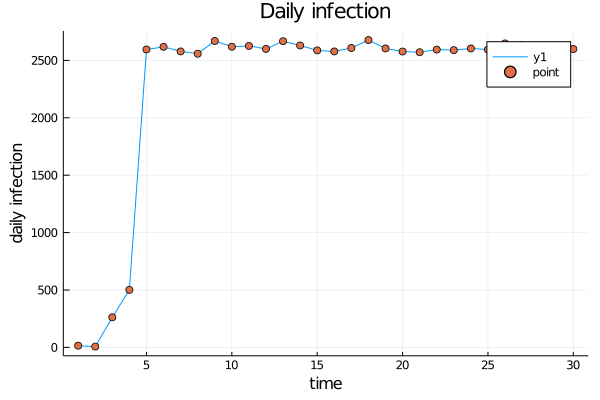

In [78]:
y = daily
x = 1:30
plot(x, y, title = "Daily infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("daily infection")

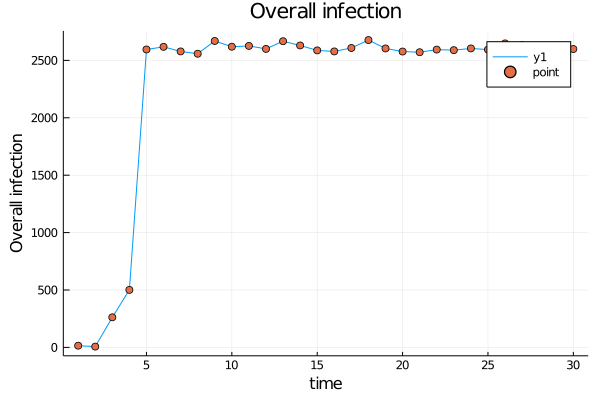

In [79]:
y = totalInfection
x = 1:30
plot(x, y, title = "Overall infection")
scatter!(x,y, label="point")
xlabel!("time")
ylabel!("Overall infection")